In [1]:
import os
import pandas as pd
import numpy as np

os.chdir("C:\\Users\\StuartWilson\\Documents\\Portfolio\\NEISS")

In [2]:
neiss = pd.read_csv('Data\\neiss.csv')
neiss.head()

c:\Users\StuartWilson\Documents\Portfolio\NEISS\Python\.venv\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (11,12,13,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Hispanic,Body_Part,Diagnosis,...,Alcohol,Drug,Narrative,Stratum,PSU,Weight,Product,Product_2,Product_3,Year
0,0,150103216,2015-01-01,2,Female,White,NaN,NaN,"Face (including eyelid, eye area and nose)","Contusions, Abrasions",...,NaN,NaN,"2 YOF,PT WAS CLIMBING ON A BAR STOOL WHEN IT F...",S,84,78.5926,barstools or kitchen stools,NaN,NaN,2015
1,1,150117280,2015-01-02,69,Female,Not Stated,NaN,NaN,Ankle,Fracture,...,NaN,NaN,69YOF FELL OFF A BAR STOOL AT HOME AND SUSTAIN...,M,63,97.9239,barstools or kitchen stools,NaN,NaN,2015
2,2,150121820,2015-01-08,2,Male,White,NaN,NaN,Head,Internal organ injury,...,NaN,NaN,02YOM AT HOME FELL OFF BAR STOOL HITTING HEAD/...,S,94,78.5926,barstools or kitchen stools,NaN,NaN,2015
3,3,150127724,2015-01-11,54,Male,Black/African American,NaN,NaN,"Trunk, lower",Strain or Sprain,...,NaN,NaN,54 Y/O M FELL OFF STOOL AND STRAINED LOWER BACK,S,70,78.5926,barstools or kitchen stools,NaN,NaN,2015
4,4,150129528,2015-01-09,2,Male,Black/African American,NaN,NaN,Head,Internal organ injury,...,NaN,NaN,2YOM FELL INTO BARSTOOL THEN TO FLOOR; DX DENT...,C,20,5.6748,barstools or kitchen stools,floors or flooring materials,NaN,2015


In [3]:
#show how many 'not recorded' in location column
len(neiss.loc[neiss['Location']=='Not recorded']) / len(neiss)

0.2835335590805327

In [4]:
#show value counts for locations after removing 'not recorded'
neiss = neiss.loc[neiss['Location'] != 'Not recorded']
neiss['Location'].value_counts()

Home                             809629
Place of recreation or sports    240277
Other public property            129423
School/Daycare                    98950
Street or highway                 39991
Farm/ranch                          639
Mobile/Manufactured home            391
Industrial                          136
Name: Location, dtype: int64

In [5]:
#remove the three locations that are rare
neiss = neiss.loc[~neiss['Location'].isin(['Farm/ranch', 'Mobile/Manufactured home', 'Industrial'])]
neiss['Location'].value_counts()

Home                             809629
Place of recreation or sports    240277
Other public property            129423
School/Daycare                    98950
Street or highway                 39991
Name: Location, dtype: int64

In [6]:
#create indicator variables for locations
neiss['Location'] = pd.Categorical(neiss['Location'])
neiss['loc_ind'] = neiss['Location'].cat.codes
neiss['loc_ind'].value_counts()


0    809629
2    240277
1    129423
3     98950
4     39991
Name: loc_ind, dtype: int64

In [7]:
# clean strings
# get rid of non alpha numeric
# fix the yof and yom
neiss['Narrative_clean'] = neiss['Narrative'].str.replace(r'[^a-zA-Z0-9 ]+', '').str.lower()
neiss['Narrative_clean'] = neiss['Narrative_clean'].str.replace('yof', ' yof ')
neiss['Narrative_clean'] = neiss['Narrative_clean'].str.replace('yom', ' yom ')
neiss['Narrative_clean'] = neiss['Narrative_clean'].str.replace('yf', ' yof ')
neiss['Narrative_clean'] = neiss['Narrative_clean'].str.replace('ym', ' yom ')
neiss['Narrative_clean'] = neiss['Narrative_clean'].str.replace('yo f', ' yof ')
neiss['Narrative_clean'] = neiss['Narrative_clean'].str.replace('yo m', ' yom ')
neiss['Narrative_clean'] = neiss['Narrative_clean'].str.replace('yr', ' yr ')
neiss['Narrative_clean'] = neiss['Narrative_clean'].str.replace('dx', ' dx ')
neiss['Narrative_clean'] = neiss['Narrative_clean'].str.replace('sx', ' sx ')
neiss['Narrative_clean'] = neiss['Narrative_clean'].str.replace('tx', ' tx ')
neiss['Narrative_clean'] = neiss['Narrative_clean'].str.replace('fx', ' fx ')
neiss['Narrative_clean'] = neiss['Narrative_clean'].str.replace('hx', ' hx ')


neiss['Narrative_clean'].head()

<ipython-input-7-37bb0c854e54>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  neiss['Narrative_clean'] = neiss['Narrative'].str.replace(r'[^a-zA-Z0-9 ]+', '').str.lower()


0    2  yof pt was climbing on a bar stool when it ...
1    69 yof  fell off a bar stool at home and susta...
2    02 yom  at home fell off bar stool hitting hea...
3      54  yom  fell off stool and strained lower back
4    2 yom  fell into barstool then to floor  dx  d...
Name: Narrative_clean, dtype: object

In [8]:
#tokenize narrative
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

neiss["Tokens"] = neiss["Narrative_clean"].apply(tokenizer.tokenize)
neiss['Tokens'].head()

0    [2, yof, pt, was, climbing, on, a, bar, stool,...
1    [69, yof, fell, off, a, bar, stool, at, home, ...
2    [02, yom, at, home, fell, off, bar, stool, hit...
3    [54, yom, fell, off, stool, and, strained, low...
4    [2, yom, fell, into, barstool, then, to, floor...
Name: Tokens, dtype: object

In [9]:
#take sample to save time fitting model
sample = neiss.sample(500000)
for ele in sample['Location'].unique():
    print(ele + ' : ' + str(len(sample.loc[sample['Location']==ele]) / len(sample)))

Home : 0.61508
Place of recreation or sports : 0.182154
Other public property : 0.097758
School/Daycare : 0.0746
Street or highway : 0.030408


In [10]:
#compare sample props to dataset prop
for ele in neiss['Location'].unique():
    print(ele + ' : ' + str(len(neiss.loc[neiss['Location']==ele]) / len(neiss)))

Home : 0.6141602251435594
Other public property : 0.0981763978547642
School/Daycare : 0.07506049595302935
Place of recreation or sports : 0.18226691042047533
Street or highway : 0.030335970628171772


In [11]:
#bag of words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

sample['Text'] = sample['Tokens'].apply(lambda x: ' '.join(x))

def cv(data):
    count_vect = CountVectorizer()
    bow = count_vect.fit_transform(data)
    return bow, count_vect

list_corpus = sample['Text'].tolist()
list_labels = sample['loc_ind'].tolist()

X_train_val, X_test, y_train_val, y_test = train_test_split(list_corpus, list_labels, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size=0.2)
X_train_counts, count_vect = cv(X_train)
X_valid_counts = count_vect.transform(X_val)

c:\Users\StuartWilson\Documents\Portfolio\NEISS\Python\.venv\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


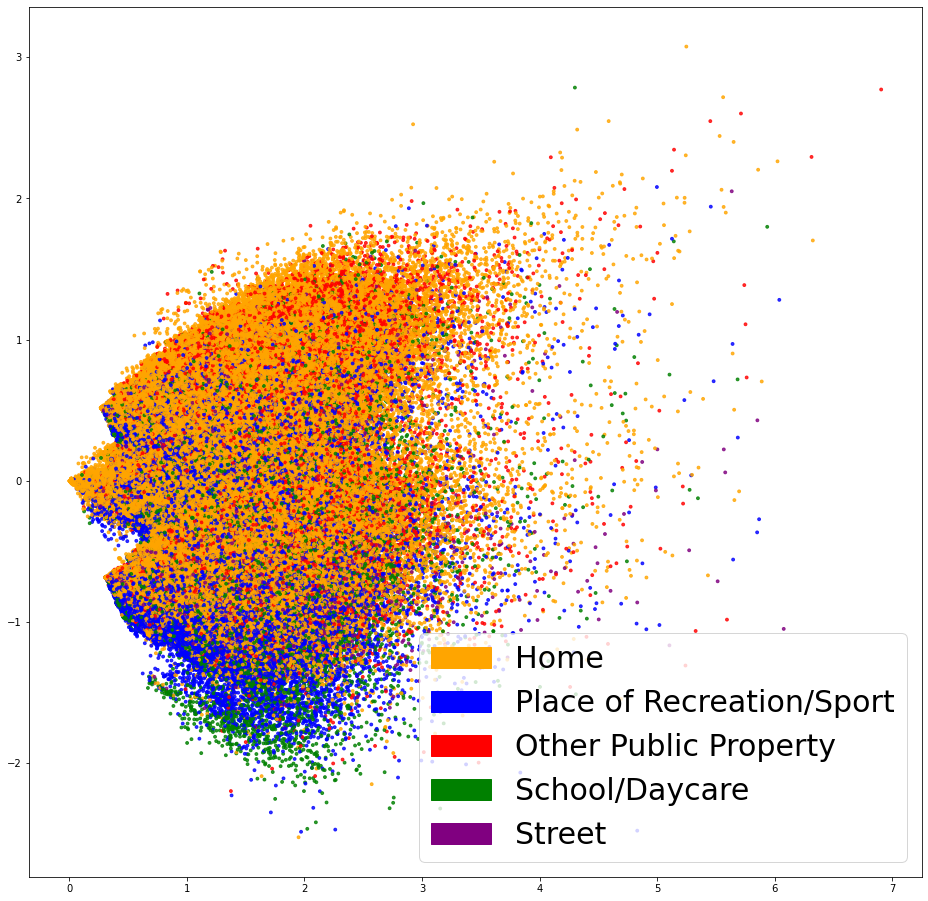

In [12]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','red','blue', 'green', 'purple']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Home')
            red_patch = mpatches.Patch(color='red', label='Other Public Property')
            blue_patch = mpatches.Patch(color='blue', label='Place of Recreation/Sport')
            green_patch = mpatches.Patch(color='green', label='School/Daycare')
            purple_patch = mpatches.Patch(color='purple', label='Street')


            plt.legend(handles=[orange_patch, blue_patch, red_patch, green_patch, purple_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

clf = LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1)
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_valid_counts)

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_val, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.911, precision = 0.910, recall = 0.911, f1 = 0.908


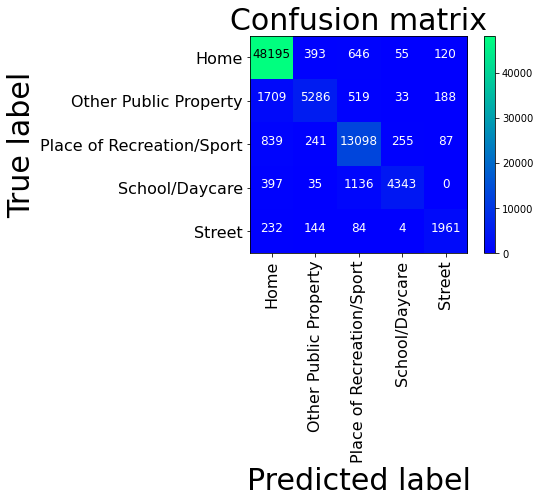

[[48195   393   646    55   120]
 [ 1709  5286   519    33   188]
 [  839   241 13098   255    87]
 [  397    35  1136  4343     0]
 [  232   144    84     4  1961]]


In [14]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=16, rotation=90)
    plt.yticks(tick_marks, classes, fontsize=16)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=12)
    
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

cm = confusion_matrix(y_val, y_predicted_counts)
plot = plot_confusion_matrix(cm, classes=['Home','Other Public Property',
                                          'Place of Recreation/Sport', 'School/Daycare',
                                          'Street'], 
                             normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\StuartWilson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
#remove stopwords
from nltk.corpus import stopwords
stopword = set(stopwords.words('english'))

def remove_stop(tokens):
    text = [word for word in tokens if word not in stopword]
    return text

sample['Tokens_nostop'] = sample['Tokens'].apply(lambda x: remove_stop(x))
sample['Tokens_nostop'].head()


538135     [27, yof, admits, drinking, etoh, per, friends...
1440505    [12, yof, home, spilled, hot, water, left, lat...
529803     [19, yom, lower, back, shoulder, pain, going, ...
1560701    [54, yof, pt, walking, dogs, jerked, leashe, h...
78325      [87, yof, uses, walker, ambulate, fell, floor,...
Name: Tokens_nostop, dtype: object

In [17]:
#no stopwords
sample['Text_nostop'] = sample['Tokens_nostop'].apply(lambda x: ' '.join(x))

list_corpus = sample['Text_nostop'].tolist()
list_labels = sample['loc_ind'].tolist()

X_train_val, X_test, y_train_val, y_test = train_test_split(list_corpus, list_labels, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size=0.2)
X_train_counts, count_vect = cv(X_train)
X_valid_counts = count_vect.transform(X_val)

clf = LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1)
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_valid_counts)

accuracy, precision, recall, f1 = get_metrics(y_val, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.906, precision = 0.905, recall = 0.906, f1 = 0.903


In [18]:
#prediction went down a bit
#try custom stopwords

In [19]:
#get list of all words
all_words = [word for line in list_corpus for word in line.split()]
all_words[:5]

['27', 'yof', 'admits', 'drinking', 'etoh']

In [20]:
from nltk.probability import FreqDist
fdist = FreqDist(all_words)
top_ten = fdist.most_common(10)
stopword = [item[0] for item in top_ten]
stopword.remove('home')
stopword

['dx', 'yom', 'yof', 'fell', 'head', 'pain', 'floor', 'hit', 'pt']

In [21]:
sample['Tokens_nostop_custom'] = sample['Tokens'].apply(lambda x: remove_stop(x))
sample['Tokens_nostop_custom'].head()

538135     [27, admits, to, drinking, etoh, and, per, fri...
1440505    [12, at, home, spilled, hot, water, on, left, ...
529803     [19, with, lower, back, and, shoulder, after, ...
1560701    [54, was, walking, her, dogs, when, the, jerke...
78325      [87, uses, walker, to, ambulate, to, going, in...
Name: Tokens_nostop_custom, dtype: object

In [22]:
sample['Text_nostop_custom'] = sample['Tokens_nostop_custom'].apply(lambda x: ' '.join(x))

list_corpus = sample['Text_nostop_custom'].tolist()
list_labels = sample['loc_ind'].tolist()

X_train_val, X_test, y_train_val, y_test = train_test_split(list_corpus, list_labels, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size=0.2)
X_train_counts, count_vect = cv(X_train)
X_valid_counts = count_vect.transform(X_val)

clf = LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1)
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_valid_counts)

accuracy, precision, recall, f1 = get_metrics(y_val, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.910, precision = 0.909, recall = 0.910, f1 = 0.907


In [23]:
#models with no stopwords do not seem to be helping predictions much
#might actually be worse

In [24]:
#lemmatize tokens
nltk.download('wordnet')
from nltk import WordNetLemmatizer 
wn = WordNetLemmatizer()

def lemmatizing(tokens):
    text = [wn.lemmatize(word) for word in tokens]
    return text

#neiss['Tokens_lemma'] = neiss['Tokens_nostop'].apply(lambda x: lemmatizing(x))
sample['Tokens_lemma'] = sample['Tokens'].apply(lambda x: lemmatizing(x))
sample['Tokens_lemma'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\StuartWilson\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


538135     [27, yof, admits, to, drinking, etoh, and, per...
1440505    [12, yof, at, home, spilled, hot, water, on, l...
529803     [19, yom, with, lower, back, and, shoulder, pa...
1560701    [54, yof, pt, wa, walking, her, dog, when, the...
78325      [87, yof, us, walker, to, ambulate, fell, to, ...
Name: Tokens_lemma, dtype: object

In [25]:
#lemma 
sample['Text_lemma'] = sample['Tokens_lemma'].apply(lambda x: ' '.join(x))

list_corpus = sample['Text_lemma'].tolist()
list_labels = sample['loc_ind'].tolist()

X_train_val, X_test, y_train_val, y_test = train_test_split(list_corpus, list_labels, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size=0.2)
X_train_counts, count_vect = cv(X_train)
X_valid_counts = count_vect.transform(X_val)

clf = LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1)
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_valid_counts)

accuracy, precision, recall, f1 = get_metrics(y_val, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.910, precision = 0.909, recall = 0.910, f1 = 0.907


In [19]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vect, clf, 10)
importance

{0: {'tops': [(2.6774816650374107, 'entertainment'),
   (2.720305309738734, 'driveway'),
   (2.724941190299339, 'basement'),
   (2.737342133524894, 'bed'),
   (2.7582326374879695, 'athome'),
   (2.8178256649711035, 'bathtub'),
   (2.9944936908572415, 'yard'),
   (3.0567673598739336, 'porch'),
   (3.896978641189093, 'home'),
   (4.189925429078404, 'backyard')],
  'bottom': [(-3.1259185274151116, 'dorm'),
   (-3.1760710695619503, 'atnursing'),
   (-3.318697547145126, 'park'),
   (-3.4101595752693057, 'restaurant'),
   (-3.5427505707432076, 'gym'),
   (-3.597697748213059, 'hotel'),
   (-3.906066741611906, 'nsg'),
   (-4.038117052532721, 'daycare'),
   (-4.947158490206142, 'group'),
   (-5.510989037568617, 'nursing')]},
 1: {'tops': [(4.062711851077958, 'mall'),
   (4.08938181741474, 'ecf'),
   (4.143412014021194, 'group'),
   (4.275659319510207, 'restaurant'),
   (4.353353579156483, 'nh'),
   (4.6153709961227385, 'store'),
   (4.701042284733527, 'jail'),
   (4.866396242304332, 'nursing'),

In [20]:
#try to find way to plot importance

In [21]:
#tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(data):
    tfidf_vect = TfidfVectorizer()

    train = tfidf_vect.fit_transform(data)

    return train, tfidf_vect

X_train_tfidf, tfidf_vect = tfidf(X_train)
X_valid_tfidf = tfidf_vect.transform(X_valid)

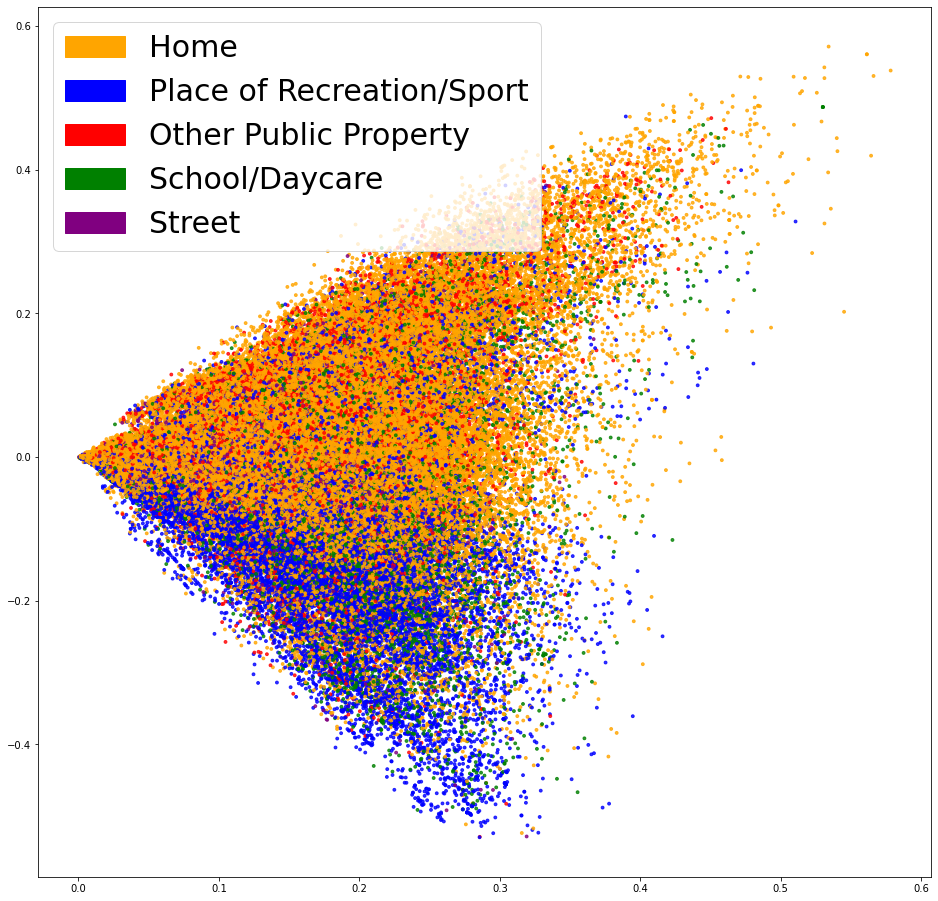

In [22]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [23]:
clf_tfidf = LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1)
clf_tfidf.fit(X_train_tfidf, y_train)
y_predicted_tfidf = clf_tfidf.predict(X_valid_tfidf)

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_valid, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.900, precision = 0.902, recall = 0.900, f1 = 0.896


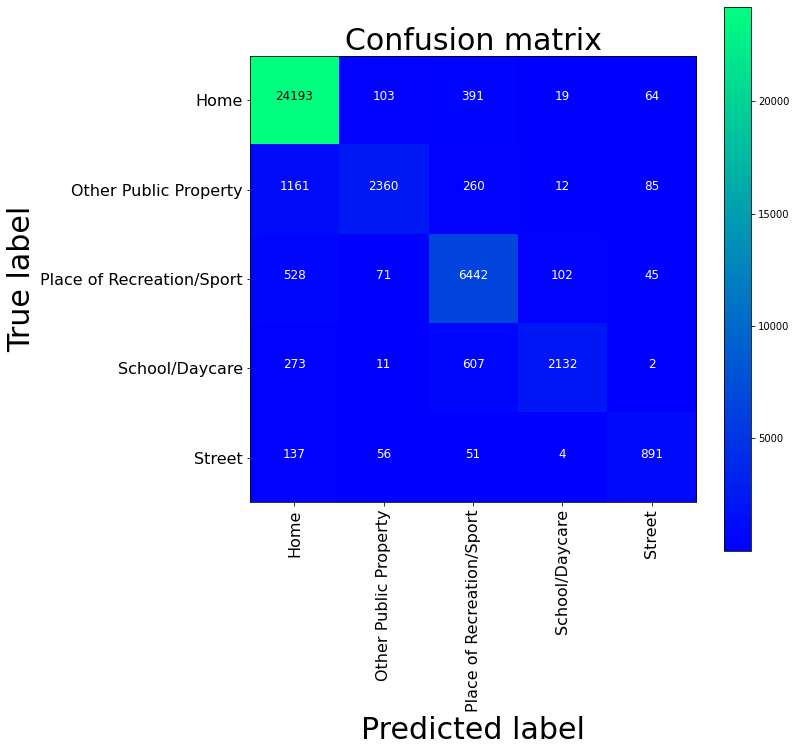

TFIDF confusion matrix
[[24193   103   391    19    64]
 [ 1161  2360   260    12    85]
 [  528    71  6442   102    45]
 [  273    11   607  2132     2]
 [  137    56    51     4   891]]
BoW confusion matrix
[[24154   158   371    26    61]
 [ 1007  2488   268    13   102]
 [  487    93  6433   138    37]
 [  242    17   580  2183     3]
 [  117    60    44     3   915]]


In [24]:
cm2 = confusion_matrix(y_valid, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Home','Other Public Property',
                                          'Place of Recreation/Sport', 'School/Daycare',
                                          'Street'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [25]:
importance_tfidf = get_most_important_features(tfidf_vect, clf_tfidf, 10)
importance_tfidf

{0: {'tops': [(5.236125382795428, 'bathtub'),
   (5.517424708927243, 'yard'),
   (5.617898111222858, 'kitchen'),
   (5.6311277846824375, 'shower'),
   (5.72520799164482, 'backyard'),
   (5.994043265069872, 'house'),
   (6.034988003588738, 'porch'),
   (6.419850587948753, 'couch'),
   (8.710272163865797, 'bed'),
   (16.015768990442595, 'home')],
  'bottom': [(-6.466333149898281, 'ecf'),
   (-6.682969697920015, 'store'),
   (-6.931349236358447, 'class'),
   (-7.042044064873122, 'nh'),
   (-7.254408470186058, 'park'),
   (-7.743535309542964, 'daycare'),
   (-8.140020815727834, 'group'),
   (-9.049263504280415, 'gym'),
   (-10.493752686740342, 'school'),
   (-13.121717169999275, 'nursing')]},
 1: {'tops': [(7.570571429532134, 'sidewalk'),
   (7.930856164183702, 'restaurant'),
   (8.482459756648318, 'group'),
   (8.663652778175765, 'ecf'),
   (8.704394552489871, 'jail'),
   (9.146590192377884, 'nh'),
   (9.300770677947552, 'hotel'),
   (9.74212475186276, 'church'),
   (10.23380631584106, 's

In [26]:
# plot importance_tfidf

In [27]:
import gensim

# Load Google's pre-trained Word2Vec model.
word2vec_path = "Data\\gensim-data\\word2vec-google-news-300\\word2vec-google-news-300.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

c:\Users\StuartWilson\Documents\Portfolio\NEISS\Python\.venv\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [28]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, text, generate_missing=False):
    embeddings = text['Tokens_lemma'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [29]:
embeddings = get_word2vec_embeddings(word2vec, sample)
X_train_word2vec, X_valid_word2vec, y_train_word2vec, y_valid_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

c:\Users\StuartWilson\Documents\Portfolio\NEISS\Python\.venv\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


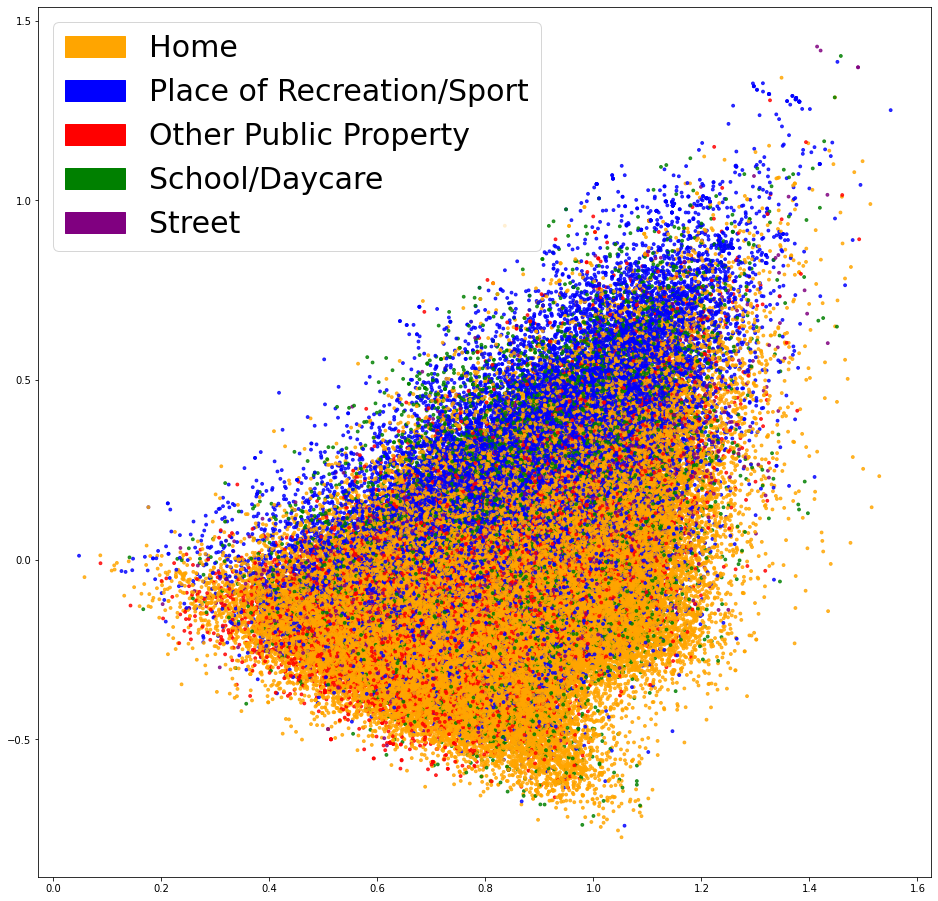

In [30]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

In [31]:
clf_w2v = LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_valid_word2vec)

accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_valid_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.857, precision = 0.853, recall = 0.857, f1 = 0.848


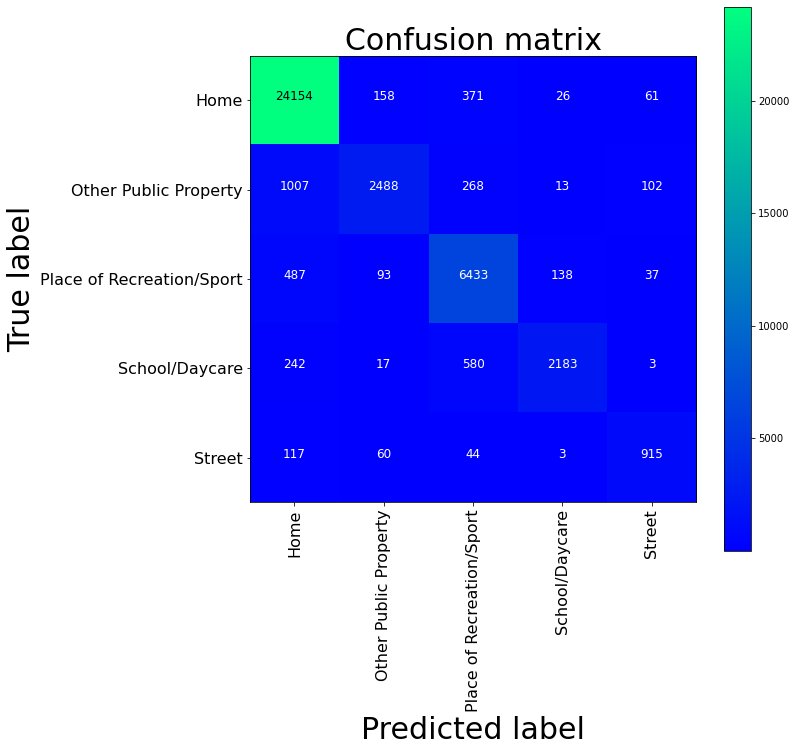

Word2Vec confusion matrix
[[23532   302   520    55    98]
 [ 1711  1721   333    28   128]
 [  871   102  6162   150    68]
 [  328    34   619  1947     4]
 [  226    75    80     3   903]]
TFIDF confusion matrix
[[24193   103   391    19    64]
 [ 1161  2360   260    12    85]
 [  528    71  6442   102    45]
 [  273    11   607  2132     2]
 [  137    56    51     4   891]]
BoW confusion matrix
[[24154   158   371    26    61]
 [ 1007  2488   268    13   102]
 [  487    93  6433   138    37]
 [  242    17   580  2183     3]
 [  117    60    44     3   915]]


In [32]:
cm_w2v = confusion_matrix(y_valid_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Home','Other Public Property',
                                          'Place of Recreation/Sport', 'School/Daycare',
                                          'Street'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [35]:
#try word2vec on full dataset because need huge corpus

In [42]:
#gridsearch for log reg
from sklearn.model_selection import GridSearchCV
params = {
          'C': [0.1, 1, 5],
          'class_weight': ['balanced', 'none'],
          'solver': ['liblinear', 'newton-cg', 'saga', 'lbfgs']
          }
clf_grid = LogisticRegression(n_jobs=-1)
gs = GridSearchCV(clf_grid, params, n_jobs=-1)
gs_fit = gs.fit(X_train_tfidf, y_train)
gs.best_params_

c:\Users\StuartWilson\Documents\Portfolio\NEISS\Python\.venv\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.87505    0.85368125 0.8536625  0.85360625        nan        nan
        nan        nan 0.89585    0.87501875 0.86703125 0.8728875
        nan        nan        nan        nan 0.89891875 0.87800625
 0.8666     0.87014375        nan        nan        nan        nan]
  warnings.warn(
c:\Users\StuartWilson\Documents\Portfolio\NEISS\Python\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


{'C': 5, 'class_weight': 'balanced', 'solver': 'liblinear'}

In [44]:
#try out on different clf models like svm, random forest, naive bayes
from sklearn.svm import SVC
params = {
          'C': [0.1, 1, 5],
          'class_weight': ['balanced', 'none'],
          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'gamma': ['scale', 'auto']
          }
clf_grid = SVC()
gs = GridSearchCV(clf_grid, params)
gs_fit = gs.fit(X_train_tfidf, y_train)
gs.best_params_

In [ ]:
from sklearn.naive_bayes import MultinomialNB
params = {
          'alpha': [0, 0.5, 1, 2, 5],
          }
clf_grid = MultinomialNB()
gs = GridSearchCV(clf_grid, params)
gs_fit = gs.fit(X_train_tfidf, y_train)
gs.best_params_

In [ ]:
#xgboost 

In [ ]:
#ensemble methods

In [37]:
#over sample because unbalanced classes